<a href="https://colab.research.google.com/github/nisalasanga/Generating-Hand-Written-Digits-Using-GAN/blob/main/239183M_Waruna_H_R_N_A_CS5802_Advanced_Machine_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyperparameters

# Root directory for dataset
dataroot = './data'

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 48

# Size of feature maps in discriminator
ndf = 48

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

sample_dir = 'samples'



In [ ]:
# Create a directory for saving generated samples
import os
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
# MNIST dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


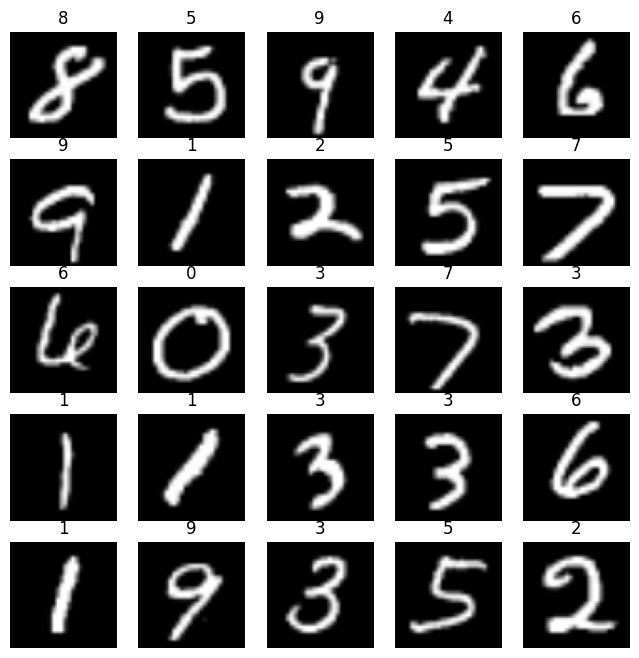

In [ ]:
# Visualizing some Images from Train Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator().to(device)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(48, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(384, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
correct = 0
total = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()



        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, nrow=10, normalize=True))

        iters += 1

Starting Training Loop...
[1/30][0/600]	Loss_D: 1.3071	Loss_G: 2.0918	D(x): 0.6035	D(G(z)): 0.5409 / 0.1272
[1/30][100/600]	Loss_D: 0.0026	Loss_G: 7.4745	D(x): 0.9993	D(G(z)): 0.0019 / 0.0006
[1/30][200/600]	Loss_D: 0.0006	Loss_G: 8.0297	D(x): 0.9999	D(G(z)): 0.0005 / 0.0003
[1/30][300/600]	Loss_D: 0.3399	Loss_G: 6.7858	D(x): 0.9660	D(G(z)): 0.2611 / 0.0012
[1/30][400/600]	Loss_D: 0.6184	Loss_G: 2.0025	D(x): 0.7233	D(G(z)): 0.2091 / 0.1523
[1/30][500/600]	Loss_D: 0.7913	Loss_G: 1.2799	D(x): 0.5572	D(G(z)): 0.1344 / 0.3182
[2/30][0/600]	Loss_D: 0.4256	Loss_G: 2.1742	D(x): 0.8164	D(G(z)): 0.1855 / 0.1305
[2/30][100/600]	Loss_D: 0.3003	Loss_G: 2.1445	D(x): 0.8286	D(G(z)): 0.0962 / 0.1316
[2/30][200/600]	Loss_D: 0.7080	Loss_G: 2.5585	D(x): 0.8388	D(G(z)): 0.3913 / 0.0868
[2/30][300/600]	Loss_D: 0.3586	Loss_G: 2.6034	D(x): 0.9066	D(G(z)): 0.2185 / 0.0871
[2/30][400/600]	Loss_D: 0.1252	Loss_G: 3.6184	D(x): 0.9511	D(G(z)): 0.0669 / 0.0374
[2/30][500/600]	Loss_D: 0.4681	Loss_G: 1.6058	D(x): 0.

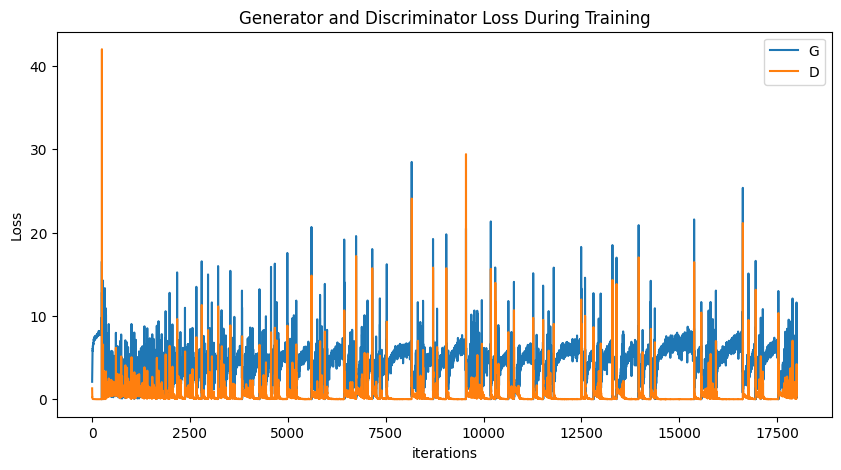

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

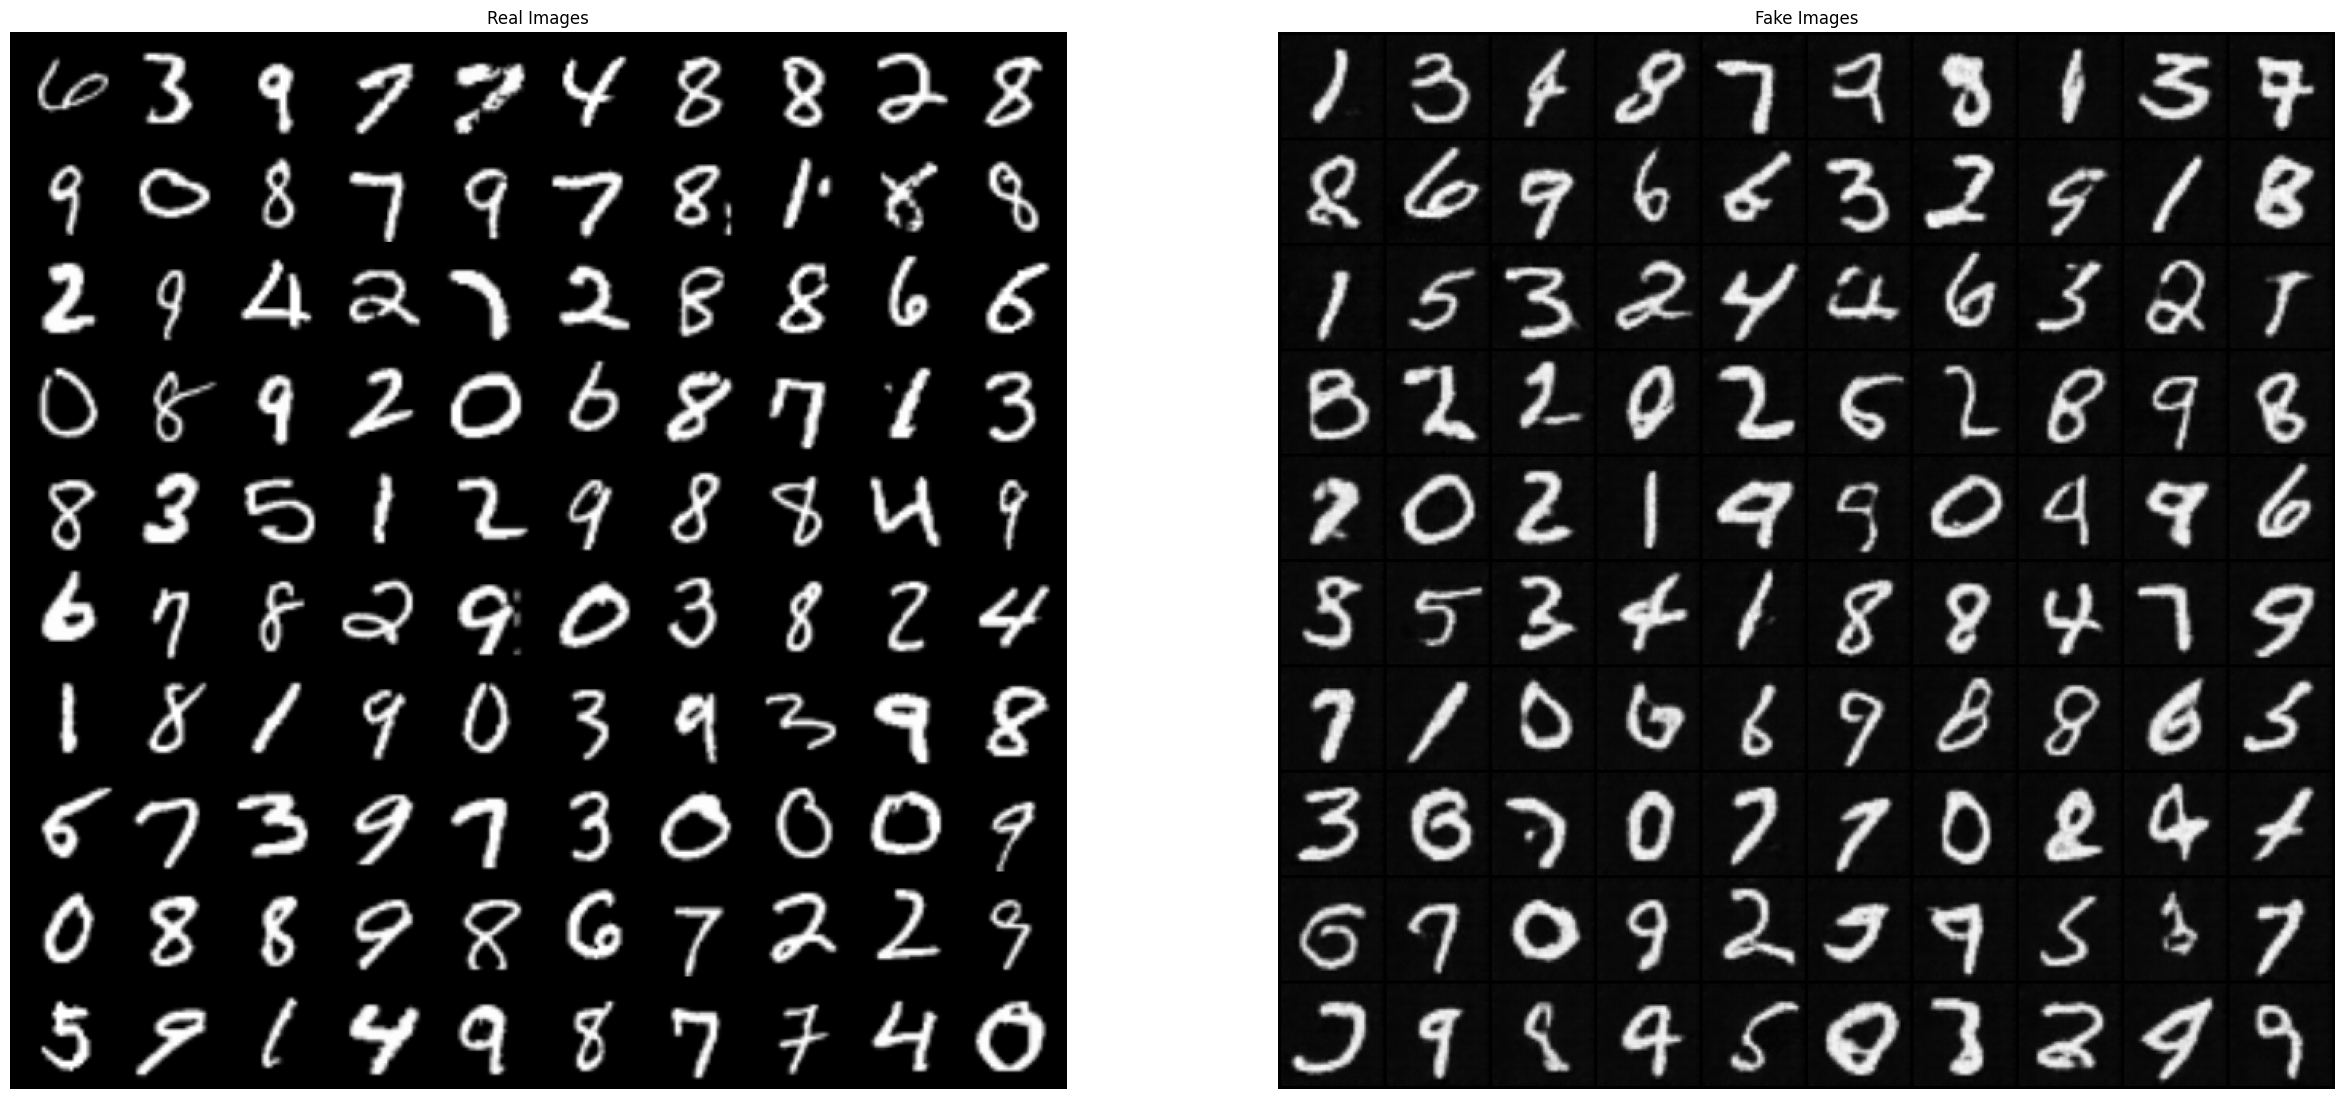

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], nrow=10, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Saving Models

# Generator Model
PATH = "G.pkl"
# Save
torch.save(netG, PATH)

# Discriminator Model
PATH = "D.pkl"
# Save
torch.save(netD, PATH)

In [ ]:
# Load
PATH = "G.pkl"

Generator_model = torch.load(PATH)
Generator_model.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 384, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(48, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
for i in range(0,100):
  # Generate a noice vector
  noise = torch.randn(1, 100, 1, 1, device=device)
  cpu_noise  = noise.cpu()
  np_arr = cpu_noise .numpy().flatten()

  # Specify the file name and extension
  file_name_txt = f'{i}.txt'

  # Save the array to the sample_dir
  file_path_txt = os.path.join(sample_dir, file_name_txt)
  np.savetxt(file_path_txt, np_arr)


  # Generating a fake image from noice
  fake = Generator_model(noise).detach().cpu()
  fake_grid = vutils.make_grid(fake, padding=2, normalize=True)

  # Save the image to the sample_dir
  file_name_img = f'img{i}.png'
  file_path_img = os.path.join(sample_dir, file_name_img)
  vutils.save_image(fake_grid, file_path_img)


In [ ]:
!zip -r ./samples.zip ./samples/

  adding: samples/ (stored 0%)
  adding: samples/img44.png (deflated 0%)
  adding: samples/img58.png (deflated 0%)
  adding: samples/img78.png (deflated 0%)
  adding: samples/45.txt (deflated 54%)
  adding: samples/img55.png (stored 0%)
  adding: samples/img72.png (deflated 0%)
  adding: samples/img97.png (stored 0%)
  adding: samples/65.txt (deflated 54%)
  adding: samples/img93.png (stored 0%)
  adding: samples/img15.png (deflated 0%)
  adding: samples/30.txt (deflated 54%)
  adding: samples/img80.png (stored 0%)
  adding: samples/76.txt (deflated 54%)
  adding: samples/img4.png (stored 0%)
  adding: samples/img85.png (stored 0%)
  adding: samples/img52.png (deflated 0%)
  adding: samples/86.txt (deflated 54%)
  adding: samples/31.txt (deflated 54%)
  adding: samples/11.txt (deflated 53%)
  adding: samples/84.txt (deflated 53%)
  adding: samples/57.txt (deflated 53%)
  adding: samples/img16.png (deflated 0%)
  adding: samples/38.txt (deflated 54%)
  adding: samples/29.txt (deflated 5

# Traning Convolution Network for classification

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import os
import numpy as np
from torchvision.datasets import ImageFolder
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
torch.manual_seed(999)

In [ ]:
n_epochs = 3
batch_size = 100
learning_rate = 0.01
momentum = 0.5
image_size = 64


In [ ]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

In [ ]:
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 50 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-4-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3068, Accuracy: 1065/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321487
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.274822
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.210652
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.021355
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.559524
Train Epoch: 1 [25000/60000 (42%)]	Loss: 1.216989
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.082559
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.870996
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.710104
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.781376
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.783494
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.621954

Test set: Avg. loss: 0.2990, Accuracy: 9194/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.654265
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.527906
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.474281
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.541548
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.491279
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.66377

In [ ]:
# Saving Model

# Convolution Model
PATH = "C.pkl"
# Save
torch.save(network, PATH)

## Testing accuracy of the Classifier model. (For the whole MNIST test data set)


In [ ]:
# Load
PATH = "C.pkl"

convolution_model = torch.load(PATH)
convolution_model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
true_label = []
pred_label = []

with torch.no_grad():
    for data, target in test_dataset:

      true_label.append(target)


      output = convolution_model(data)
      pred = output.data.max(1, keepdim=True)[1].item()
      pred_label.append(pred)



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
<ipython-input-69-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
print("Accuarcy score for test dataset:",accuracy_score(true_label, pred_label))

Accuarcy score for test dataset: 0.9616


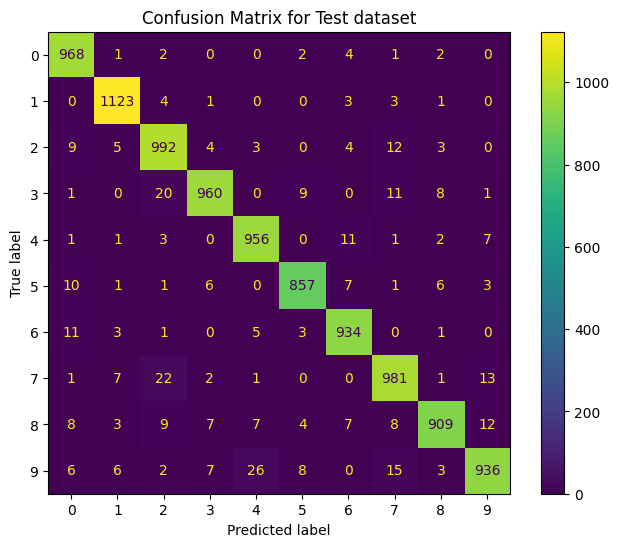

In [ ]:
conf_matrix = confusion_matrix(true_label, pred_label)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
label_classses = np.unique(true_label)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_classses)
ax.set(title='Confusion Matrix for Test dataset')
display.plot(ax=ax)


# 3. Evaluate the new fake data set

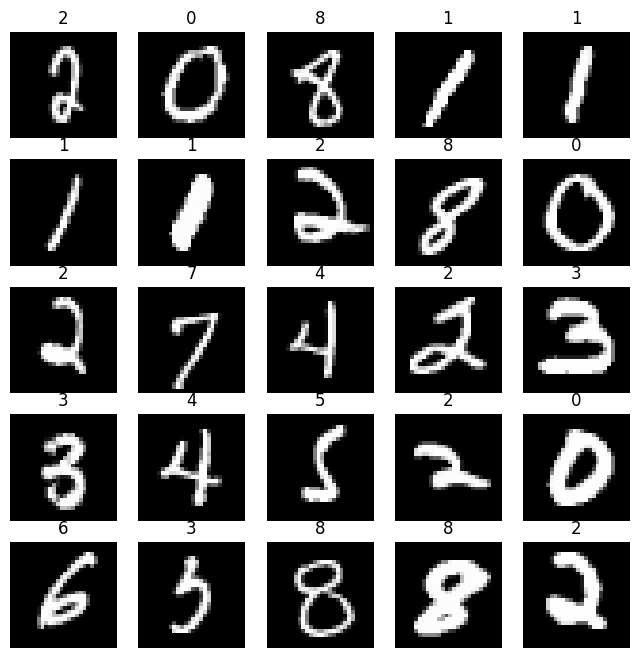

In [ ]:
# Visualizing some Images from Test Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
!unzip -uq "Fake_Digits.zip"

In [ ]:
import os
from PIL import Image
import numpy as np

# Set the path to the dataset folder in Colab
dataset_dir = "Fake Digits"

# Define the target size for resizing the images
target_size = (28, 28)  # Example target size

dataset = []
labels = []

# Iterate over the subfolders in the dataset folder
for class_label in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_label)
    if os.path.isdir(class_dir):
        # Iterate over the files in the subfolder
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)

            try:
                # Attempt to open the file as an image
                image = Image.open(file_path)
                image = image.resize(target_size)  # Resize the image to the target size
                #image = np.array(image,dtype='float64')  # Convert the image to a numpy array
                image.convert("L")

                dataset.append(image)
                labels.append(class_label)

            except (IOError, OSError):
                # Skip the file if it's not a valid image
                print(f"Skipping file: {file_path}")

Skipping file: Fake Digits/7/7_006.txt
Skipping file: Fake Digits/7/7_083.txt
Skipping file: Fake Digits/7/7_078.txt
Skipping file: Fake Digits/7/7_066.txt
Skipping file: Fake Digits/7/7_030.txt
Skipping file: Fake Digits/7/7_059.txt
Skipping file: Fake Digits/7/7_012.txt
Skipping file: Fake Digits/7/7_038.txt
Skipping file: Fake Digits/7/7_036.txt
Skipping file: Fake Digits/2/2_023.txt
Skipping file: Fake Digits/2/2_099.txt
Skipping file: Fake Digits/2/2_097.txt
Skipping file: Fake Digits/2/2_074.txt
Skipping file: Fake Digits/1/1_050.txt
Skipping file: Fake Digits/1/1_031.txt
Skipping file: Fake Digits/1/1_039.txt
Skipping file: Fake Digits/1/1_075.txt
Skipping file: Fake Digits/1/1_007.txt
Skipping file: Fake Digits/1/1_015.txt
Skipping file: Fake Digits/1/1_017.txt
Skipping file: Fake Digits/1/1_090.txt
Skipping file: Fake Digits/1/1_022.txt
Skipping file: Fake Digits/1/1_046.txt
Skipping file: Fake Digits/1/1_060.txt
Skipping file: Fake Digits/0/0_045.txt
Skipping file: Fake Digit

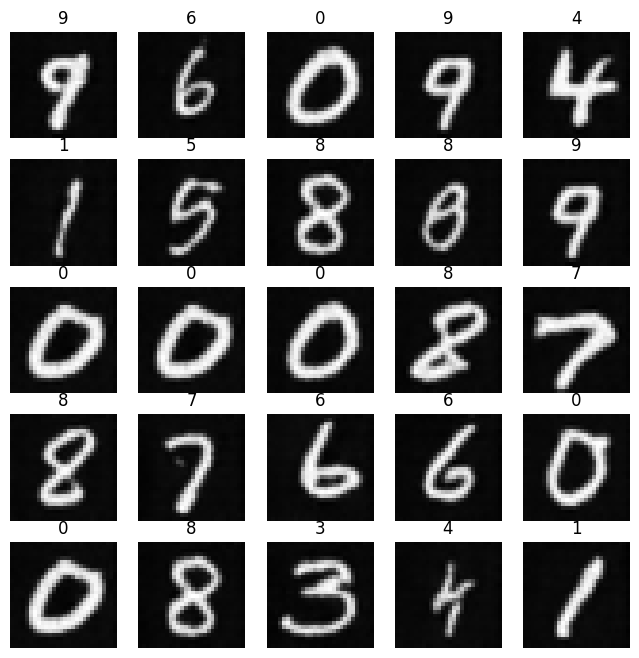

In [ ]:
# Visualizing some Images from fake images Dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx],labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
# Load
PATH = "C.pkl"

convolution_model = torch.load(PATH)
convolution_model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
grayscale_image = image.convert("L")

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

pred_class_labels = []  # Store the predicted class labels

for image in dataset:
    transformed_image = transform(image)  # Add a batch dimension

    transformed_image = transformed_image.unsqueeze(0)

    # Forward pass through the model
    with torch.no_grad():
        output = convolution_model(transformed_image)

    # Get the predicted class label
    _, predicted_class = torch.max(output, 1)
    class_label = predicted_class.item()
    pred_class_labels.append(class_label)


labels = np.array(labels,dtype='int')

print("Accuracy Score for fake digit dataset: ",accuracy_score(labels, pred_class_labels))

Accuracy Score for fake digit dataset:  0.99


<ipython-input-7-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


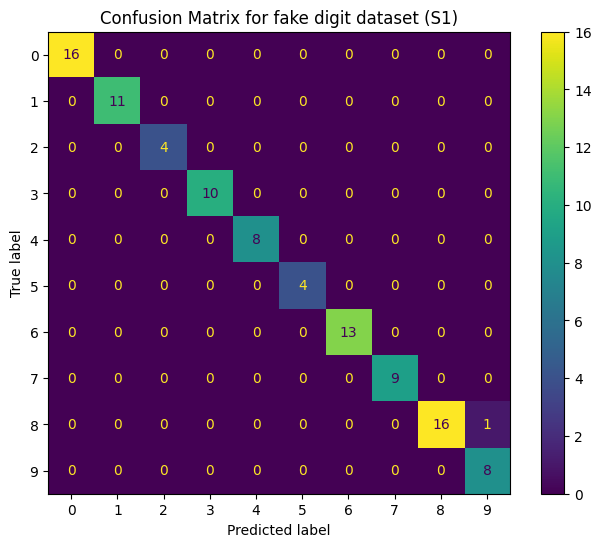

In [ ]:
conf_matrix = confusion_matrix(labels, pred_class_labels)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
label_classses = np.unique(labels)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_classses)
ax.set(title='Confusion Matrix for fake digit dataset (S1)')
display.plot(ax=ax)


In [ ]:
predict = []
labels = []

torch.manual_seed(999)

with torch.no_grad():
  for i in range(0, 100):
      sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
      img, label = train_dataset[sample_idx]


      outputs = convolution_model(img)
      _, predicted = torch.max(outputs.data, 1)

      labels.append(label)

      class_label = predicted.item()
      predict.append(class_label)

print("Accuracy Score for test dataset: ",accuracy_score(labels, predict))

Accuracy Score for test dataset:  0.95


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "
<ipython-input-7-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


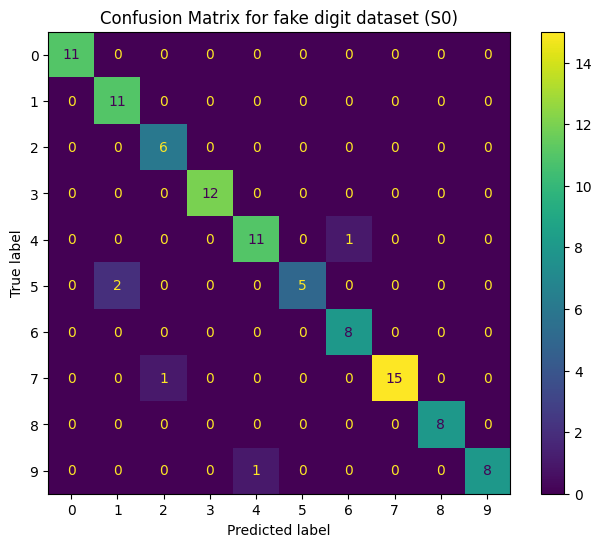

In [ ]:
conf_matrix = confusion_matrix(labels, predict)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
label_classses = np.unique(labels)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=label_classses)
ax.set(title='Confusion Matrix for fake digit dataset (S0)')
display.plot(ax=ax)
